## Power calculations

In [195]:
#Packages 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [196]:
#Fixed input values

v = 1*10**(-6) #kinematic viscosity
rho = 1000
g = 9.81
x = 2 #number of screws
eta_0 = 0.7
eta_r = 0.98
eta_t = 0.98
eta_g = 0.96

In [197]:
#Fixed input values, ship related

L = 67.02 
B = 8.02
T = 1.5
C_B = 0.922218
P_installed = 435 #kW
C_BB = 0.185

c_stern = 0
one_k2 = 1.5 #appendage resistance factor

print(T)

1.5


In [198]:
#Ship related values, calculated from fixed input values

C_M = 1.006 - 0.0056 * C_B **(-3.56)
C_wp = (1+2 * C_B)/3
C_p = C_B / C_M

delta = C_B * L * B * T #water displacement

lcb = -13.5 + 19.4 * C_p
L_R = L * (1 - C_p + (0.06 * C_p * lcb)/(4 * C_p -1))

A_BT = C_BB * B * T * C_M
A_T = 0.1 * B * T

S_T = L*(2*T + B) * np.sqrt(C_M) * (0.453 + 0.4425 * C_B - 0.2862* C_M - 0.003467 * (B/T) + 0.3696 * C_wp) + 2.38 * (A_BT / C_B)
S_APP = 0.05 * S_T
S_B = L * B

D_s = 0.7 * T

In [199]:
#Variables
V_0 = 4.5 #m/s
#V_0 = np.linspace(0, 5.0, 101)
#h = np.linspace(3.0, 15.0, 101)
h = 10

In [200]:
#Section 2.2 Resistance

#Section 2.2.1 Frictional resistance

R_e = V_0 * L / v
D = h - T #distance from bottom ship to the bottom of the fairway

Cf_0 = 0.075 / ((np.log10(R_e)-2)**2)
Cf_proposed = (0.08169/((np.log10(R_e) - 1.717)**2)) * (1 + (0.003998/(np.log10(R_e) - 4.393)) * (D/L)**(-1.083))

a = 0.042612 * np.log10(R_e) + 0.56725
Cf_katsui = 0.0066577 / ((np.log10(R_e) - 4.3762)**a)

V_B = 0.4277 * V_0 * np.exp((h / T)**(-0.07625))

C_f = Cf_0 + (Cf_proposed - Cf_katsui) * (S_B / S_T) * (V_B / V_0)**2

R_f = (C_f * 0.5 * rho * (V_0**2) * S_T) / 1000 #kN

In [201]:
#Section 2.2.2 Viscous resistance

c_14 = 1 + 0.0011 * c_stern
one_k1 = 0.93+0.487 * c_14 * ((B/L)**1.068) * ((T/L)**0.461) * ((L/L_R)**0.122) * (((L**3)/delta)**0.365) * ((1 - C_p)**(-0.604))

In [202]:
#Section 2.2.3 Appendage resistance

R_APP = (0.5 * rho * (V_0**2) * S_APP * one_k2 * C_f) / 1000 #kN

In [203]:
#Section 2.2.4 Wave resistance

F_n = V_0 / np.sqrt(g*L) #Froude number

#coefficient c_7
if B/L < 0.11:
    c_7 = 0.229577 * (B/L)**0.33333
elif B/L > 0.25:
    c_7 = 0.5 - 0.0625 * (L/B)
else:
    c_7 = B/L
            
i_E = 125.67 * (B/L) - 162.25 * (C_p ** 2) + 234.32 * (C_p ** 3) + 0.155087 * (lcb ** 3)
c_1 = 2223105 * (c_7 ** 3.78613) * ((T/B)**1.07961) * ((90 - i_E)**(-1.37565))

c_3 = 0.56 * (A_BT ** 1.5) / (B * T * (0.31 * np.sqrt(A_BT) + T - 0.5*T))
c_2 = np.exp(-1.89 * np.sqrt(c_3))
c_5 = 1 - 0.8 * A_T / (B * T * C_M)

#coefficient c_16
if C_p < 0.80:
    c_16 = 8.07981 * C_p - (13.8673 * C_p ** 2) + (6.984388 * C_p ** 3)
else:
    c_16 = 1.73014 - 0.7067 * C_p

m_1 = 0.0140407 * (L/T) - (1.75254 * delta**(1/3))/L - 4.79323 * (B/L) - c_16

#coefficient c_15
if (L**3)/delta < 512:
    c_15 = -1.69385
elif (L**3)/delta > 1727:
    c_15 = 0
else:
    c_15 = -1.69385 + (L / (delta**(1/3)) - 8.0) / 2.36

m_2 = c_15 * (C_p**2) * np.exp(-0.1 * (F_n)**(-2))

#coefficient lambda
if L/B < 12:
    lmbda = 1.446 * C_p - 0.03 * (L/B)
else:
    lmbda = 1.446 * C_p - 0.36
    

R_W = (c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_n**-0.9) + m_2 * np.cos(lmbda * (F_n**(-2))))) / 1000 #kN

In [204]:
#Section 2.2.5 Residual resistance terms

#Resistance resulting from the bulbouw bow
P_B = 0.56 * np.sqrt(A_BT) / (T - 1.5 * 0.5*T)
F_ni = V_0 / np.sqrt(g * (T - 0.5*T - 0.25*np.sqrt(A_BT)) + 0.15*(V_0**2))


R_B = (0.11 * np.exp(-3 * P_B**(-2)) * (F_ni**3) * (A_BT**1.5) * rho * g / (1 + (F_ni**2))) / 1000 #kN


#Resistance due to immersed transom
F_nt = V_0 / np.sqrt(2 * g * A_T / (B + B * C_wp))


c_6 = 0.2 * (1 - 0.2 * F_nt)

#c_6 = np.zeros(101)
#counter = 0 


#for i in F_nt:
    #if i < 5:
        #c_6[counter] = 0.2 * (1 - 0.2 * i)
    #else:
        #c_6[counter] = 0
    
    #counter += 1
    
R_TR = (0.5 * rho * (V_0**2) * A_T * c_6) / 1000 #kN


#Model-ship correlation resistance
if T/L > 0.04:
    c_4 = 0.04
else:
    c_4 = T / L
    
C_A = 0.006 * ((L + 100)**(-0.16)) - 0.00205 + 0.003 * np.sqrt(L/7.5) * (C_B**4) * c_2 * (0.04 - c_4)

R_A = (0.5 * rho * (V_0**2) * S_T * C_A) / 1000 #kW

In [205]:
#Section 2.2 Resistance

#Total resistance

R_tot = R_f * one_k1 + R_APP + R_W + R_B + R_TR + R_A

In [206]:
#Section 2.1 Total required power

#2.1.1 Required power for systems on board
P_hotel = 0.081 * P_installed

#2.1.2 Required power for propulsion

#Effective Horse Power (EHP)
P_EHP = V_B * R_tot

dw = 0 

#dw = np.zeros(101)
#counter = 0 

#Calculation hull efficiency
#for i in F_n:
    #if i < 0.2:
        #dw[counter] = 0
    #else:
        #dw[counter] = 0.1
    
    #counter += 1
    
w = 0.11 * (0.16 / x) * C_B * np.sqrt((delta**(1/3)) / D_s) - dw

if x == 1:
    t = 0.6 * w * (1 + 0.67 * w)
else:
    t = 0.8 * w * (1 + 0.25 * w)
    
eta_h = (1 - t) / (1 - w)

#Delivered Horse Power (DHP)

P_DHP = P_EHP / (eta_0 * eta_r * eta_h)

#Brake Horse Power (BHP)
P_BHP = P_DHP / (eta_t * eta_g)

P_tot = P_hotel + P_BHP

print('The total power required is', P_tot, 'kW')

P_partial = P_tot / P_installed

print('The partial load is', P_partial)

The total power required is 380.6540692748701 kW
The partial load is 0.8750668259192416


## Required energy during delta t

In [207]:
#Testcase
delta_t = (1195.9037) / 3600
delta_E = P_tot * delta_t
print(delta_E)

126.45155829607597


## Emission calculations

In the following code, functions are defined to calculate the emission factor.

The emission factor depends on the age of the engine. The age of the engine is determined according to a weibull function. Depending on the weight class of the vessel (L1, L2, L3), the vessel has a different weibull function. With a random generator the age of the vessel is drawn. (see function: calculate_engine_age) With the age of the engine, the construction  year of the engine is calculated (c_year). 

For testing purposes, a cell is included were the construction year of the engine is hardcoded. 

After the construction year has been determined, the corresponding general emission factor can be determined (for CO2, NOX, PM10) - (see function: general_emissionfactor).

The general emission factor has to be applied by a correction factor, which accounts for the partial engine load. If the partial engine load is low, the correction factors are higher (so the engine works less efficient). 

In [208]:
#Age of vessel of weight class L1, L2 or L3 

def calculate_engine_age(L_w=1):
    #Determining which shape and scale factor to use, based on the weight class L_w = L1, L2 or L3
    if L_w == 1:     #Weight class L1
        k = 1.3
        lmb = 20.5
    if L_w == 2:     #Weight class L2
        k = 1.12
        lmb = 18.5
    if L_w == 3:     #Weight class L3
        k = 1.26
        lmb = 18.6
            
    #The age of the engine
    age = int(np.random.weibull(k)*lmb)
        
    #Current year (TO DO: fix hardcoded year)
    year = 2020
        
    #Construction year of the engine
    c_year = year - age   
    return c_year

    
print(calculate_engine_age())

2003


In [209]:
c_year = 2015 #hardcoded, so 'ignoring' the cell above

In [210]:
def general_emissionfactor(c_year, L):
    if c_year < 1974:
        EM_CO2 = 756
        EM_PM10 = 0.6
        EM_NOX = 10.8
    if 1975 <= c_year <= 1979:
        EM_CO2 = 730
        EM_PM10 = 0.6
        EM_NOX = 10.6
    if 1980 <= c_year <= 1984:
        EM_CO2 = 714
        EM_PM10 = 0.6
        EM_NOX = 10.4
    if 1985 <= c_year <= 1989:
        EM_CO2 = 698
        EM_PM10 = 0.5
        EM_NOX = 10.1
    if 1990 <= c_year <= 1994:
        EM_CO2 = 698
        EM_PM10 = 0.4
        EM_NOX = 10.1
    if 1995 <= c_year <= 2002:
        EM_CO2 = 650
        EM_PM10 = 0.3
        EM_NOX = 9.4
    if 2003 <= c_year <= 2007:
        EM_CO2 = 635
        EM_PM10 = 0.3
        EM_NOX = 9.2
    if 2008 <= c_year <= 2019:
        EM_CO2 = 635
        EM_PM10 = 0.2
        EM_NOX = 7
    if c_year > 2019:
        if L == 1:
            EM_CO2 = 650
            EM_PM10 = 0.1
            EM_NOX = 2.9
        else:
            EM_CO2 = 603
            EM_PM10 = 0.0015
            EM_NOX = 2.4
    return EM_CO2, EM_PM10, EM_NOX

general_emf = general_emissionfactor(c_year, 1)

In [211]:
#Correctionfactor function, which reads the right values from the correction factor table, based on the partial engine load
#Partial engine load = P_partial
#And based on the construction year of the engine (c_year), which has influence on the correction factors of NOX

def correctionfactor(c_year, P_partial, L_w=1):
    
    corf = pd.read_excel (r'correctionfactors.xlsx')
    
    for i in range(20):
    #If the partial engine load is smaller or equal to 5%, the correction factors corresponding to P_partial = 5% are assigned.
        if P_partial <= corf.iloc[0, 0]:
            corf_CO2 = corf.iloc[0, 5]
            corf_PM10 = corf.iloc[0, 6]
            
            #The NOX correction factors are dependend on the construction year of the engine and the weight class
            if c_year < 2008:
                corf_NOX = corf.iloc[0, 1] #<= CCR-1 class
            if 2008 <= c_year <= 2019:
                corf_NOX = corf.iloc[0, 2] #CCR-2 / Stage IIIa
            if c_year > 2019:
                if L == 1:
                    corf_NOX = corf.iloc[0, 3] #Stage V: IWP/IWA-v/c-3 class (vessels with P <300 kW: assumed to be weight class L1)
                else:
                    corf_NOX = corf.iloc[0, 4]  #Stage V:IWP/IWA-v/c-4 class (vessels with P >300 kw: assumed to be weight class L2-L3)
    
        #If the partial engine load is greater than 5%:
        #It is determined inbetween which two percentages in the table the partial engine load lies
        #The correction factor is determined by means of linear interpolation  
        
        elif corf.iloc[i, 0] < P_partial <= corf.iloc[i + 1, 0]:
            corf_CO2 = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 5] - corf.iloc[i, 5])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 5]
            corf_PM10 = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 6] - corf.iloc[i, 6])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 6]
            
            if c_year < 2008:
                corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 1] - corf.iloc[i, 1])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 1]
            if 2008 <= c_year <= 2019:
                corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 2] - corf.iloc[i, 2])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 2]
            if c_year > 2019:
                if L_w == 1:
                    corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 3] - corf.iloc[i, 3])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 3]
                else:
                    corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 4] - corf.iloc[i, 4])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 4]
    return corf_CO2, corf_PM10, corf_NOX

corf = correctionfactor(c_year, P_partial, 1)

In [212]:
#The total emission factor is calculated by multiplying the general emission factor (EM_CO2 / EM_PM10 / EM_NOX)
# By the correction factor (corf_CO2 / corf_PM10 / corf_NOX)

Emf_CO2 = general_emf[0] * corf[0]
Emf_PM10 = general_emf[1] * corf[1]
Emf_NOX = general_emf[2] * corf[2]

print('The general emission factor of CO2 is', general_emf[0])
print('The general emission factor of PM10 is', general_emf[1])
print('The general emission factor of NOx is', general_emf[2])
print()
print('The correction factor of CO2 is', corf[0])
print('The correction factor of PM10 is', corf[1])
print('The correction factor of NOx is', corf[2])
print()
print('The total emission factor of CO2 is', Emf_CO2)
print('The total emission factor of PM10 is', Emf_PM10)
print('The total emission factor of NOX is', Emf_NOX)

The general emission factor of CO2 is 635
The general emission factor of PM10 is 0.2
The general emission factor of NOx is 7

The correction factor of CO2 is 1.0050133651838484
The correction factor of PM10 is 0.97
The correction factor of NOx is 1.04

The total emission factor of CO2 is 638.1834868917438
The total emission factor of PM10 is 0.194
The total emission factor of NOX is 7.28


## Total emissions during delta t

In [213]:
#We already calculated the delta_E (the energy needed during delta t)
#We can calculate the emissions by multiplying the delta_E [kWh] by the total emission factor [g / kWh]

delta_CO2 = delta_E * Emf_CO2
delta_PM10 = delta_E * Emf_PM10
delta_NOX = delta_E * Emf_NOX

print('The CO2 emission during delta t are', delta_CO2, 'g')
print('The PM10 emission during delta t are', delta_PM10, 'g')
print('The NOX emission during delta t are', delta_NOX, 'g')

The CO2 emission during delta t are 80699.29639628438 g
The PM10 emission during delta t are 24.53160230943874 g
The NOX emission during delta t are 920.5673443954331 g


In [214]:
#Total emission Zuid-Beveland route (+/- 70 km) (with 1 m/s, it takes a ship 70076 s)
tot_E = P_tot * (70076/ V_0 / 3600)
tot_CO2 = P_tot * (70076/ V_0 / 3600) * Emf_CO2
tot_PM10 = P_tot * (70076/ V_0 / 3600) * Emf_PM10
tot_NOX = P_tot * (70076/ V_0 / 3600) * Emf_NOX

print('P_tot is', P_tot)
print('P_partial is', P_partial)
print('tot_E is', tot_E)
print('tot_CO2 is', tot_CO2)
print('tot_PM10 is', tot_PM10)
print('tot_NOX is', tot_NOX)

P_tot is 380.6540692748701
P_partial is 0.8750668259192416
tot_E is 1646.587318426284
tot_CO2 is 1050824.8363450118
tot_PM10 is 319.4379397746991
tot_NOX is 11987.155678143346


## Plots

Text(0.5, 1.0, 'Vessel speed versus required power (L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')

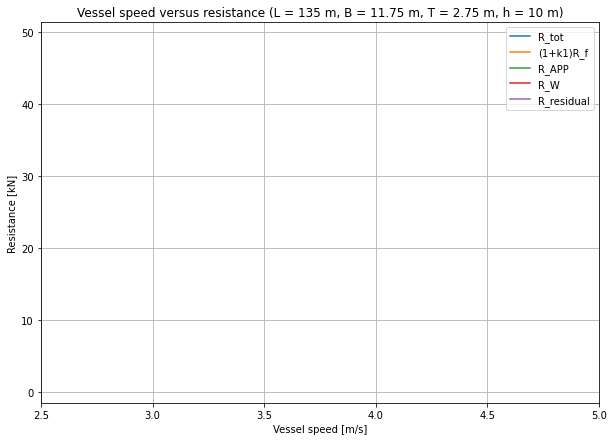

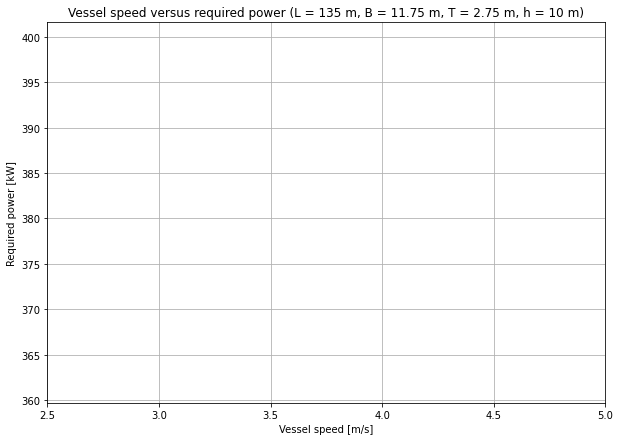

In [215]:
#When h is fixed

#Please note: make V0 variable (it is now fixed to check output)

#Vessel speed versus resistance
plt.figure(figsize=(10,7))
plt.plot(V_0, R_tot)
plt.plot(V_0, one_k1*R_f)
plt.plot(V_0, R_APP)
plt.plot(V_0, R_W)
plt.plot(V_0, R_B + R_TR + R_A)
plt.grid()
plt.xlim(2.5, 5.0)
plt.legend(['R_tot', '(1+k1)R_f', 'R_APP', 'R_W', 'R_residual'])
plt.xlabel('Vessel speed [m/s]')
plt.ylabel('Resistance [kN]')
plt.title('Vessel speed versus resistance (L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')

#Vessel speed versus required power
plt.figure(figsize=(10,7))
plt.plot(V_0, P_tot)
plt.xlim(2.5, 5.0)
plt.grid()
plt.xlabel('Vessel speed [m/s]')
plt.ylabel('Required power [kW]')
plt.title('Vessel speed versus required power (L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')

In [216]:
P_tot

380.6540692748701